[View in Colaboratory](https://colab.research.google.com/github/yylonly/GoogleCoLab/blob/master/4_ServeNet_1_BI_LTSM_LeNet_(1024_512)_(Glove200b_trainedEmbeddingLayer).ipynb)

## ServeNet-LTSM (Glove50b-trainedEmbeddingLayer)

In [0]:
!pkill -9 -f ipykernel_launcher

In [1]:
!/opt/bin/nvidia-smi
printm()

Thu May 10 07:30:04 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

NameError: ignored

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))


Gen RAM Free: 12.6 GB  I Proc size: 140.9 MB
GPU RAM Free: 11438MB | Used: 1MB | Util   0% | Total 11439MB


In [0]:
!kill -9 -1

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
import os
os.chdir("/content/drive/Colab Notebooks/")

In [3]:
!ls -l

total 17705
drwxr-xr-x 2 root root    4096 Mar  1 05:18 10.TensorFlow
drwxr-xr-x 2 root root    4096 Mar  1 07:27 14.Residual Networks
drwxr-xr-x 2 root root    4096 Mar  1 16:08 15.CarDetectionwithYOLOv2
drwxr-xr-x 2 root root    4096 Mar  1 16:27 16.Neural Style Transfer
drwxr-xr-x 2 root root    4096 Mar  1 18:00 17.Face Recognition
-rw-r--r-- 1 root root    1191 May  6 10:15 1D-CNN-BI-LTSM-glove50-loss.pdf
-rw-r--r-- 1 root root    1191 May  6 10:15 1DCNN-BI-LTSM-glove50-top5.pdf
drwxr-xr-x 2 root root    4096 Sep 15  2017 1.Python Basics with Numpy
drwxr-xr-x 2 root root    4096 Mar  1 06:26 2.Logistic Regression as a Neural Network
-rw-r--r-- 1 root root  702911 May  7 22:21 4.ServeNet-1-BI-LTSM(1024) (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  764050 May  7 19:01 4.ServeNet-1-BI-LTSM(128) (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  741240 May  8 06:23 4.ServeNet-1-BI-LTSM(512) (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root 

In [4]:
#import plaidml.keras
#plaidml.keras.install_backend()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import h5py
import pandas as pd

#from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.models import load_model
from keras import metrics
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Conv2D, Reshape, Average, Flatten, MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint
from keras.layers.wrappers import Bidirectional

np.random.seed(0)
%matplotlib inline

Using TensorFlow backend.


In [5]:
h5f = h5py.File('data/SplittedPaddedIndexedServiceDataset.h5','r') 
X_train = h5f['indexed_padded_Train_X'][:]
Y_train = h5f['Train_Y_one_hot'][:]
X_test = h5f['indexed_padded_Test_X'][:]
Y_test = h5f['Test_Y_one_hot'][:]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
h5f.close()

(8123, 110) (8123, 50)
(2061, 110) (2061, 50)


In [6]:
X_train[0]

array([192973,  54273, 270501, 294803, 286278, 121851, 360915, 363921,
       270193, 219115, 154323, 278439, 291761, 191811, 191143, 270193,
       133719, 142813, 388756, 306178, 104329, 142808, 374253, 357266,
       286278, 354433,  54718, 345909, 236860, 142838,  90548, 327482,
       357354, 209662, 374253,  43010, 111455,  91182, 156214,  58791,
       270501,  57488,  54718, 149979, 136170, 270927, 294049,  43010,
       332120, 186717,  69725,  57459, 151349,  86371, 191143, 219115,
        57840, 386474,  58997,  89857, 156216, 122453, 374163, 182908,
       199199, 113067, 360915, 111448, 156216, 386474,  58997, 357412,
       182158, 269798, 357266, 286278,  54718, 107110,  88126, 354433,
       151349, 219113, 360915, 191135, 388711, 357266, 325899, 268046,
       325776, 188836, 281890,  61645, 373469, 363840,  54718,  61640,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0], dtype=int32)

In [7]:
Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [0]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.200d.txt')

In [0]:
# GRADED FUNCTION: pretrained_embedding_layer

def trainable_embedding_layer():
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        embedding_vector = word_to_vec_map.get(word)
        if embedding_vector is not None:
            emb_matrix[index, :] = embedding_vector

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [0]:
# Epoch 15/50
#8123/8123 [==============================] - 50s 6ms/step - loss: 0.1432 - categorical_accuracy: 0.9669 - top_k_categorical_accuracy: 0.9993 - val_loss: 1.6528 - val_categorical_accuracy: 0.6395 - val_top_k_categorical_accuracy: 0.8845

# def ServeNet(input_shape):
#     """
#     Function creating the Emojify-v2 model's graph.
    
#     Arguments:
#     input_shape -- shape of the input, usually (max_len,)
#     word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
#     word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

#     Returns:
#     model -- a model instance in Keras
#     """
    
#     ### START CODE HERE ###
#     # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
#     sentence_indices = Input(shape=input_shape, dtype='int32')
    
#     # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
#     embedding_layer = trainable_embedding_layer()
    
#     # Propagate sentence_indices through your embedding layer, you get back the embeddings
#     embeddings = embedding_layer(sentence_indices) 
     
#     embeddings = Reshape((110, 200, 1))(embeddings)
    
#     features1 = Conv2D(64, kernel_size=(3, 3), padding='same')(embeddings)
#     features2 = Conv2D(1, kernel_size=(1, 1), padding='same')(features1)
#     features = Reshape((110, 200))(features2)
     
#     print(features)
      
#     # Propagate X trough another LSTM layer with 128-dimensional hidden state
#     # Be careful, the returned output should be a single hidden state, not a batch of sequences.
#     X = Bidirectional(LSTM(512, return_sequences=False))(features)
#     # Add dropout with a probability of 0.5
#     X = Dropout(0.5)(X)
#     # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
#     X = Dense(50)(X)
#     # Add a softmax activation
#     X = Activation('softmax')(X)
    
#     # Create Model instance which converts sentence_indices into X.
#     model = Model(inputs=sentence_indices, outputs=X)
    
#     ### END CODE HERE ###
    
#     return model

In [0]:
def ServeNet(input_shape):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = trainable_embedding_layer()
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices) 
     
      
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    #s, h, c = Bidirectional(LSTM(2048, return_sequences=False, return_state = True))(embeddings)
    x = Bidirectional(LSTM(512, return_sequences=False))(embeddings)
    # Add dropout with a probability of 0.5
    #X = Dropout(0.5)(X)
    
    print(x)
    
    lstm_feature = Reshape((32, 32, 1))(x)
    
    features2 = Conv2D(64, kernel_size=(5, 5), activation='relu')(lstm_feature)
    features2 = MaxPooling2D(pool_size=(2, 2))(features2)
    #features2 = Dropout(0.2)(features2)
    features3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(features2)
    features3 = MaxPooling2D(pool_size=(2, 2))(features3)
    #features3 = Dropout(0.2)(features3)
    features4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(features3)
    features4 = MaxPooling2D(pool_size=(2, 2))(features4)
    
    features5 = Conv2D(512, kernel_size=(2, 2), activation='relu')(features4)
    
    cnn_feature = Flatten()(features5)
     
    print(cnn_feature)
    
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(1024, activation='tanh')(cnn_feature)
    X = Dense(50, activation='softmax')(X)
    
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [0]:
maxLen = 110

In [28]:
model = ServeNet((maxLen, ))
model.summary()

Tensor("bidirectional_6/concat:0", shape=(?, 1024), dtype=float32)
Tensor("flatten_2/Reshape:0", shape=(?, ?), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 110)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 110, 200)          80000200  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 1024)              2920448   
_________________________________________________________________
reshape_6 (Reshape)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 64)        0         
________________

In [0]:
adam = Adam(lr=0.002, beta_1=0.5, beta_2=0.999, decay=0.0001)

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[metrics.categorical_accuracy, metrics.top_k_categorical_accuracy])

In [31]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 50, batch_size = 64)

Train on 8123 samples, validate on 2061 samples
Epoch 1/50
8123/8123 [==============================] - 74s 9ms/step - loss: 3.7792 - categorical_accuracy: 0.0646 - top_k_categorical_accuracy: 0.2467 - val_loss: 3.6850 - val_categorical_accuracy: 0.0747 - val_top_k_categorical_accuracy: 0.2678
Epoch 2/50
5376/8123 [==================>...........] - ETA: 22s - loss: 3.7232 - categorical_accuracy: 0.0698 - top_k_categorical_accuracy: 0.2587

8123/8123 [==============================] - 72s 9ms/step - loss: 3.7122 - categorical_accuracy: 0.0700 - top_k_categorical_accuracy: 0.2638 - val_loss: 3.6498 - val_categorical_accuracy: 0.0878 - val_top_k_categorical_accuracy: 0.2950
Epoch 3/50
8123/8123 [==============================] - 72s 9ms/step - loss: 3.6320 - categorical_accuracy: 0.0938 - top_k_categorical_accuracy: 0.3137 - val_loss: 3.3734 - val_categorical_accuracy: 0.1378 - val_top_k_categorical_accuracy: 0.3843
Epoch 4/50
4480/8123 [===============>..............] - ETA: 30s - loss: 3.2380 - categorical_accuracy: 0.1547 - top_k_categorical_accuracy: 0.4277

8123/8123 [==============================] - 72s 9ms/step - loss: 3.1220 - categorical_accuracy: 0.1833 - top_k_categorical_accuracy: 0.4649 - val_loss: 2.9391 - val_categorical_accuracy: 0.2276 - val_top_k_categorical_accuracy: 0.5114
Epoch 5/50
8123/8123 [==============================] - 72s 9ms/step - loss: 2.6743 - categorical_accuracy: 0.2807 - top_k_categorical_accuracy: 0.6051 - val_loss: 2.5947 - val_categorical_accuracy: 0.2974 - val_top_k_categorical_accuracy: 0.6400
Epoch 6/50
4288/8123 [==============>...............] - ETA: 31s - loss: 2.2962 - categorical_accuracy: 0.3589 - top_k_categorical_accuracy: 0.7048

8123/8123 [==============================] - 72s 9ms/step - loss: 2.2135 - categorical_accuracy: 0.3848 - top_k_categorical_accuracy: 0.7244 - val_loss: 2.2042 - val_categorical_accuracy: 0.3984 - val_top_k_categorical_accuracy: 0.7234
Epoch 7/50
8123/8123 [==============================] - 72s 9ms/step - loss: 1.8220 - categorical_accuracy: 0.4891 - top_k_categorical_accuracy: 0.8003 - val_loss: 2.0324 - val_categorical_accuracy: 0.4726 - val_top_k_categorical_accuracy: 0.7501
Epoch 8/50
4224/8123 [==============>...............] - ETA: 32s - loss: 1.4804 - categorical_accuracy: 0.5758 - top_k_categorical_accuracy: 0.8561

8123/8123 [==============================] - 72s 9ms/step - loss: 1.5068 - categorical_accuracy: 0.5729 - top_k_categorical_accuracy: 0.8515 - val_loss: 2.0760 - val_categorical_accuracy: 0.5002 - val_top_k_categorical_accuracy: 0.7744
Epoch 9/50
8123/8123 [==============================] - 72s 9ms/step - loss: 1.2863 - categorical_accuracy: 0.6339 - top_k_categorical_accuracy: 0.8881 - val_loss: 2.0702 - val_categorical_accuracy: 0.5133 - val_top_k_categorical_accuracy: 0.7797
Epoch 10/50
4224/8123 [==============>...............] - ETA: 31s - loss: 0.9298 - categorical_accuracy: 0.7280 - top_k_categorical_accuracy: 0.9339

8123/8123 [==============================] - 71s 9ms/step - loss: 0.9430 - categorical_accuracy: 0.7251 - top_k_categorical_accuracy: 0.9357 - val_loss: 2.1354 - val_categorical_accuracy: 0.5308 - val_top_k_categorical_accuracy: 0.7855
Epoch 11/50
8123/8123 [==============================] - 71s 9ms/step - loss: 0.7595 - categorical_accuracy: 0.7768 - top_k_categorical_accuracy: 0.9526 - val_loss: 2.3887 - val_categorical_accuracy: 0.5260 - val_top_k_categorical_accuracy: 0.7686
Epoch 12/50
4224/8123 [==============>...............] - ETA: 32s - loss: 0.5437 - categorical_accuracy: 0.8407 - top_k_categorical_accuracy: 0.9732

8123/8123 [==============================] - 72s 9ms/step - loss: 0.5758 - categorical_accuracy: 0.8291 - top_k_categorical_accuracy: 0.9701 - val_loss: 2.4802 - val_categorical_accuracy: 0.5483 - val_top_k_categorical_accuracy: 0.7720
Epoch 13/50
8123/8123 [==============================] - 72s 9ms/step - loss: 0.4221 - categorical_accuracy: 0.8722 - top_k_categorical_accuracy: 0.9817 - val_loss: 2.8144 - val_categorical_accuracy: 0.5332 - val_top_k_categorical_accuracy: 0.7666
Epoch 14/50
4224/8123 [==============>...............] - ETA: 31s - loss: 0.3229 - categorical_accuracy: 0.9013 - top_k_categorical_accuracy: 0.9893

8123/8123 [==============================] - 71s 9ms/step - loss: 0.3277 - categorical_accuracy: 0.9010 - top_k_categorical_accuracy: 0.9879 - val_loss: 3.0162 - val_categorical_accuracy: 0.5371 - val_top_k_categorical_accuracy: 0.7749
Epoch 15/50
8123/8123 [==============================] - 71s 9ms/step - loss: 0.2711 - categorical_accuracy: 0.9199 - top_k_categorical_accuracy: 0.9915 - val_loss: 3.0779 - val_categorical_accuracy: 0.5386 - val_top_k_categorical_accuracy: 0.7792
Epoch 16/50
4224/8123 [==============>...............] - ETA: 32s - loss: 0.2141 - categorical_accuracy: 0.9389 - top_k_categorical_accuracy: 0.9946

8123/8123 [==============================] - 71s 9ms/step - loss: 0.2303 - categorical_accuracy: 0.9320 - top_k_categorical_accuracy: 0.9936 - val_loss: 3.2358 - val_categorical_accuracy: 0.5376 - val_top_k_categorical_accuracy: 0.7661
Epoch 17/50
8123/8123 [==============================] - 71s 9ms/step - loss: 0.2046 - categorical_accuracy: 0.9396 - top_k_categorical_accuracy: 0.9948 - val_loss: 3.3796 - val_categorical_accuracy: 0.5429 - val_top_k_categorical_accuracy: 0.7754
Epoch 18/50
4224/8123 [==============>...............] - ETA: 31s - loss: 0.1187 - categorical_accuracy: 0.9661 - top_k_categorical_accuracy: 0.9979

8123/8123 [==============================] - 71s 9ms/step - loss: 0.1217 - categorical_accuracy: 0.9641 - top_k_categorical_accuracy: 0.9979 - val_loss: 3.6671 - val_categorical_accuracy: 0.5444 - val_top_k_categorical_accuracy: 0.7671
Epoch 19/50
8123/8123 [==============================] - 71s 9ms/step - loss: 0.1577 - categorical_accuracy: 0.9563 - top_k_categorical_accuracy: 0.9974 - val_loss: 3.7442 - val_categorical_accuracy: 0.5478 - val_top_k_categorical_accuracy: 0.7603
Epoch 20/50
4224/8123 [==============>...............] - ETA: 31s - loss: 0.1215 - categorical_accuracy: 0.9659 - top_k_categorical_accuracy: 0.9974

8123/8123 [==============================] - 71s 9ms/step - loss: 0.1322 - categorical_accuracy: 0.9600 - top_k_categorical_accuracy: 0.9977 - val_loss: 3.7686 - val_categorical_accuracy: 0.5221 - val_top_k_categorical_accuracy: 0.7647
Epoch 21/50
8123/8123 [==============================] - 71s 9ms/step - loss: 0.1467 - categorical_accuracy: 0.9551 - top_k_categorical_accuracy: 0.9980 - val_loss: 3.6887 - val_categorical_accuracy: 0.5454 - val_top_k_categorical_accuracy: 0.7661
Epoch 22/50
4224/8123 [==============>...............] - ETA: 31s - loss: 0.1445 - categorical_accuracy: 0.9567 - top_k_categorical_accuracy: 0.9988

8123/8123 [==============================] - 71s 9ms/step - loss: 0.1430 - categorical_accuracy: 0.9564 - top_k_categorical_accuracy: 0.9983 - val_loss: 3.6297 - val_categorical_accuracy: 0.5405 - val_top_k_categorical_accuracy: 0.7559
Epoch 23/50
8123/8123 [==============================] - 71s 9ms/step - loss: 0.1385 - categorical_accuracy: 0.9622 - top_k_categorical_accuracy: 0.9980 - val_loss: 3.6082 - val_categorical_accuracy: 0.5318 - val_top_k_categorical_accuracy: 0.7603
Epoch 24/50
4224/8123 [==============>...............] - ETA: 32s - loss: 0.0935 - categorical_accuracy: 0.9735 - top_k_categorical_accuracy: 0.9988

8123/8123 [==============================] - 71s 9ms/step - loss: 0.0872 - categorical_accuracy: 0.9757 - top_k_categorical_accuracy: 0.9990 - val_loss: 3.8346 - val_categorical_accuracy: 0.5274 - val_top_k_categorical_accuracy: 0.7579
Epoch 25/50
8123/8123 [==============================] - 71s 9ms/step - loss: 0.0494 - categorical_accuracy: 0.9858 - top_k_categorical_accuracy: 0.9995 - val_loss: 4.0171 - val_categorical_accuracy: 0.5502 - val_top_k_categorical_accuracy: 0.7695
Epoch 26/50
4224/8123 [==============>...............] - ETA: 32s - loss: 0.0585 - categorical_accuracy: 0.9837 - top_k_categorical_accuracy: 0.9998

8123/8123 [==============================] - 72s 9ms/step - loss: 0.0723 - categorical_accuracy: 0.9792 - top_k_categorical_accuracy: 0.9995 - val_loss: 4.1789 - val_categorical_accuracy: 0.5323 - val_top_k_categorical_accuracy: 0.7574
Epoch 27/50
8123/8123 [==============================] - 70s 9ms/step - loss: 0.0670 - categorical_accuracy: 0.9810 - top_k_categorical_accuracy: 0.9995 - val_loss: 4.1137 - val_categorical_accuracy: 0.5444 - val_top_k_categorical_accuracy: 0.7705
Epoch 28/50
4224/8123 [==============>...............] - ETA: 31s - loss: 0.0662 - categorical_accuracy: 0.9827 - top_k_categorical_accuracy: 0.9993

8123/8123 [==============================] - 71s 9ms/step - loss: 0.0796 - categorical_accuracy: 0.9761 - top_k_categorical_accuracy: 0.9993 - val_loss: 3.9086 - val_categorical_accuracy: 0.5488 - val_top_k_categorical_accuracy: 0.7715
Epoch 29/50
8123/8123 [==============================] - 72s 9ms/step - loss: 0.1068 - categorical_accuracy: 0.9712 - top_k_categorical_accuracy: 0.9993 - val_loss: 3.9226 - val_categorical_accuracy: 0.5391 - val_top_k_categorical_accuracy: 0.7623
Epoch 30/50
4224/8123 [==============>...............] - ETA: 32s - loss: 0.0651 - categorical_accuracy: 0.9804 - top_k_categorical_accuracy: 0.9995

8123/8123 [==============================] - 72s 9ms/step - loss: 0.0781 - categorical_accuracy: 0.9775 - top_k_categorical_accuracy: 0.9995 - val_loss: 3.9889 - val_categorical_accuracy: 0.5405 - val_top_k_categorical_accuracy: 0.7681
Epoch 31/50
8123/8123 [==============================] - 71s 9ms/step - loss: 0.0607 - categorical_accuracy: 0.9817 - top_k_categorical_accuracy: 0.9998 - val_loss: 4.1878 - val_categorical_accuracy: 0.5488 - val_top_k_categorical_accuracy: 0.7763
Epoch 32/50
4224/8123 [==============>...............] - ETA: 32s - loss: 0.0500 - categorical_accuracy: 0.9856 - top_k_categorical_accuracy: 0.9998

8123/8123 [==============================] - 71s 9ms/step - loss: 0.0566 - categorical_accuracy: 0.9847 - top_k_categorical_accuracy: 0.9996 - val_loss: 4.1706 - val_categorical_accuracy: 0.5478 - val_top_k_categorical_accuracy: 0.7705
Epoch 33/50
8123/8123 [==============================] - 71s 9ms/step - loss: 0.0446 - categorical_accuracy: 0.9887 - top_k_categorical_accuracy: 0.9993 - val_loss: 4.0893 - val_categorical_accuracy: 0.5478 - val_top_k_categorical_accuracy: 0.7787
Epoch 34/50
4224/8123 [==============>...............] - ETA: 32s - loss: 0.0257 - categorical_accuracy: 0.9934 - top_k_categorical_accuracy: 0.9998

8123/8123 [==============================] - 71s 9ms/step - loss: 0.0241 - categorical_accuracy: 0.9943 - top_k_categorical_accuracy: 0.9998 - val_loss: 4.1432 - val_categorical_accuracy: 0.5619 - val_top_k_categorical_accuracy: 0.7778
Epoch 35/50
8123/8123 [==============================] - 71s 9ms/step - loss: 0.0144 - categorical_accuracy: 0.9977 - top_k_categorical_accuracy: 0.9999 - val_loss: 4.2220 - val_categorical_accuracy: 0.5657 - val_top_k_categorical_accuracy: 0.7749
Epoch 36/50
4224/8123 [==============>...............] - ETA: 31s - loss: 0.0063 - categorical_accuracy: 0.9986 - top_k_categorical_accuracy: 0.9998

8123/8123 [==============================] - 71s 9ms/step - loss: 0.0073 - categorical_accuracy: 0.9985 - top_k_categorical_accuracy: 0.9998 - val_loss: 4.2874 - val_categorical_accuracy: 0.5711 - val_top_k_categorical_accuracy: 0.7865
Epoch 37/50
8123/8123 [==============================] - 71s 9ms/step - loss: 0.0053 - categorical_accuracy: 0.9990 - top_k_categorical_accuracy: 0.9999 - val_loss: 4.3569 - val_categorical_accuracy: 0.5721 - val_top_k_categorical_accuracy: 0.7812
Epoch 38/50
4160/8123 [==============>...............] - ETA: 32s - loss: 0.0021 - categorical_accuracy: 0.9993 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 71s 9ms/step - loss: 0.0033 - categorical_accuracy: 0.9995 - top_k_categorical_accuracy: 0.9999 - val_loss: 4.3765 - val_categorical_accuracy: 0.5691 - val_top_k_categorical_accuracy: 0.7846
Epoch 39/50
8123/8123 [==============================] - 71s 9ms/step - loss: 0.0036 - categorical_accuracy: 0.9993 - top_k_categorical_accuracy: 0.9999 - val_loss: 4.3888 - val_categorical_accuracy: 0.5725 - val_top_k_categorical_accuracy: 0.7841
Epoch 40/50
4160/8123 [==============>...............] - ETA: 32s - loss: 3.2316e-04 - categorical_accuracy: 1.0000 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 71s 9ms/step - loss: 0.0023 - categorical_accuracy: 0.9999 - top_k_categorical_accuracy: 0.9999 - val_loss: 4.4386 - val_categorical_accuracy: 0.5687 - val_top_k_categorical_accuracy: 0.7846
Epoch 41/50
8123/8123 [==============================] - 71s 9ms/step - loss: 0.0022 - categorical_accuracy: 0.9999 - top_k_categorical_accuracy: 0.9999 - val_loss: 4.4630 - val_categorical_accuracy: 0.5701 - val_top_k_categorical_accuracy: 0.7831
Epoch 42/50
4096/8123 [==============>...............] - ETA: 32s - loss: 1.8447e-04 - categorical_accuracy: 1.0000 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 71s 9ms/step - loss: 0.0022 - categorical_accuracy: 0.9999 - top_k_categorical_accuracy: 0.9999 - val_loss: 4.4911 - val_categorical_accuracy: 0.5706 - val_top_k_categorical_accuracy: 0.7836
Epoch 43/50
8123/8123 [==============================] - 71s 9ms/step - loss: 0.0021 - categorical_accuracy: 0.9999 - top_k_categorical_accuracy: 0.9999 - val_loss: 4.5197 - val_categorical_accuracy: 0.5687 - val_top_k_categorical_accuracy: 0.7841
Epoch 44/50
4160/8123 [==============>...............] - ETA: 32s - loss: 0.0040 - categorical_accuracy: 0.9998 - top_k_categorical_accuracy: 0.9998

8123/8123 [==============================] - 71s 9ms/step - loss: 0.0021 - categorical_accuracy: 0.9999 - top_k_categorical_accuracy: 0.9999 - val_loss: 4.5463 - val_categorical_accuracy: 0.5682 - val_top_k_categorical_accuracy: 0.7851
Epoch 45/50
8123/8123 [==============================] - 71s 9ms/step - loss: 0.0021 - categorical_accuracy: 0.9999 - top_k_categorical_accuracy: 0.9999 - val_loss: 4.5637 - val_categorical_accuracy: 0.5687 - val_top_k_categorical_accuracy: 0.7846
Epoch 46/50
4160/8123 [==============>...............] - ETA: 32s - loss: 9.4529e-05 - categorical_accuracy: 1.0000 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 71s 9ms/step - loss: 0.0021 - categorical_accuracy: 0.9999 - top_k_categorical_accuracy: 0.9999 - val_loss: 4.5858 - val_categorical_accuracy: 0.5696 - val_top_k_categorical_accuracy: 0.7846
Epoch 47/50
8123/8123 [==============================] - 71s 9ms/step - loss: 0.0021 - categorical_accuracy: 0.9999 - top_k_categorical_accuracy: 0.9999 - val_loss: 4.6017 - val_categorical_accuracy: 0.5691 - val_top_k_categorical_accuracy: 0.7831
Epoch 48/50
4160/8123 [==============>...............] - ETA: 32s - loss: 0.0040 - categorical_accuracy: 0.9998 - top_k_categorical_accuracy: 0.9998

8123/8123 [==============================] - 71s 9ms/step - loss: 0.0021 - categorical_accuracy: 0.9999 - top_k_categorical_accuracy: 0.9999 - val_loss: 4.6185 - val_categorical_accuracy: 0.5706 - val_top_k_categorical_accuracy: 0.7841
Epoch 49/50
8123/8123 [==============================] - 71s 9ms/step - loss: 0.0020 - categorical_accuracy: 0.9999 - top_k_categorical_accuracy: 0.9999 - val_loss: 4.6373 - val_categorical_accuracy: 0.5706 - val_top_k_categorical_accuracy: 0.7836
Epoch 50/50
4160/8123 [==============>...............] - ETA: 32s - loss: 5.8683e-05 - categorical_accuracy: 1.0000 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 71s 9ms/step - loss: 0.0020 - categorical_accuracy: 0.9999 - top_k_categorical_accuracy: 0.9999 - val_loss: 4.6514 - val_categorical_accuracy: 0.5691 - val_top_k_categorical_accuracy: 0.7836


In [32]:
!ls -l

total 17690
drwxr-xr-x 2 root root    4096 Mar  1 05:18 10.TensorFlow
drwxr-xr-x 2 root root    4096 Mar  1 07:27 14.Residual Networks
drwxr-xr-x 2 root root    4096 Mar  1 16:08 15.CarDetectionwithYOLOv2
drwxr-xr-x 2 root root    4096 Mar  1 16:27 16.Neural Style Transfer
drwxr-xr-x 2 root root    4096 Mar  1 18:00 17.Face Recognition
-rw-r--r-- 1 root root    1191 May  6 10:15 1D-CNN-BI-LTSM-glove50-loss.pdf
-rw-r--r-- 1 root root    1191 May  6 10:15 1DCNN-BI-LTSM-glove50-top5.pdf
drwxr-xr-x 2 root root    4096 Sep 15  2017 1.Python Basics with Numpy
drwxr-xr-x 2 root root    4096 Mar  1 06:26 2.Logistic Regression as a Neural Network
-rw-r--r-- 1 root root  702911 May  7 22:21 4.ServeNet-1-BI-LTSM(1024) (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  764050 May  7 19:01 4.ServeNet-1-BI-LTSM(128) (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  741240 May  8 06:23 4.ServeNet-1-BI-LTSM(512) (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root 

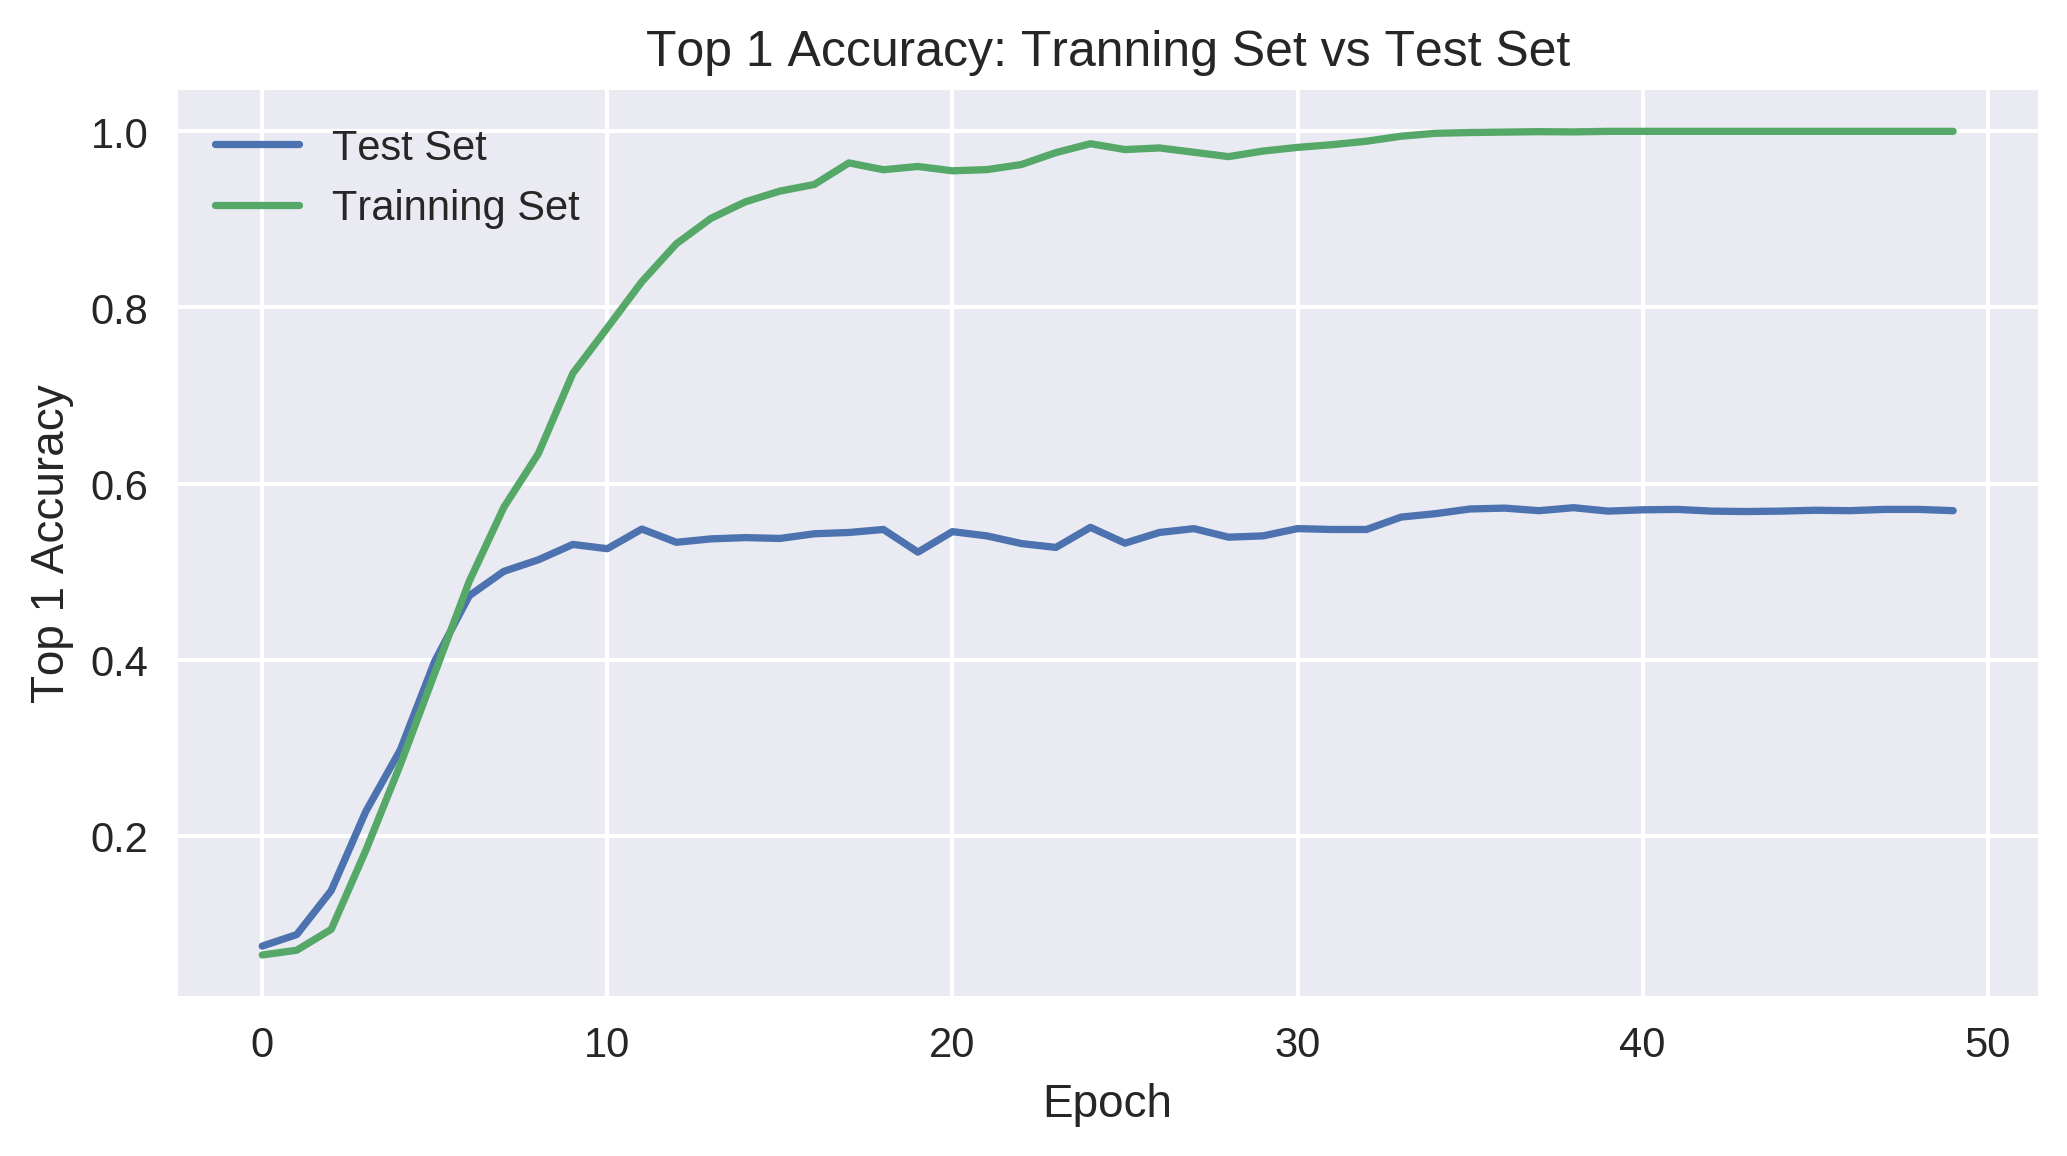

In [33]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 1 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 1 Accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="Test Set")
plt.plot(history.history['categorical_accuracy'], label="Trainning Set")
plt.legend()
plt.show()

### Plot Loss

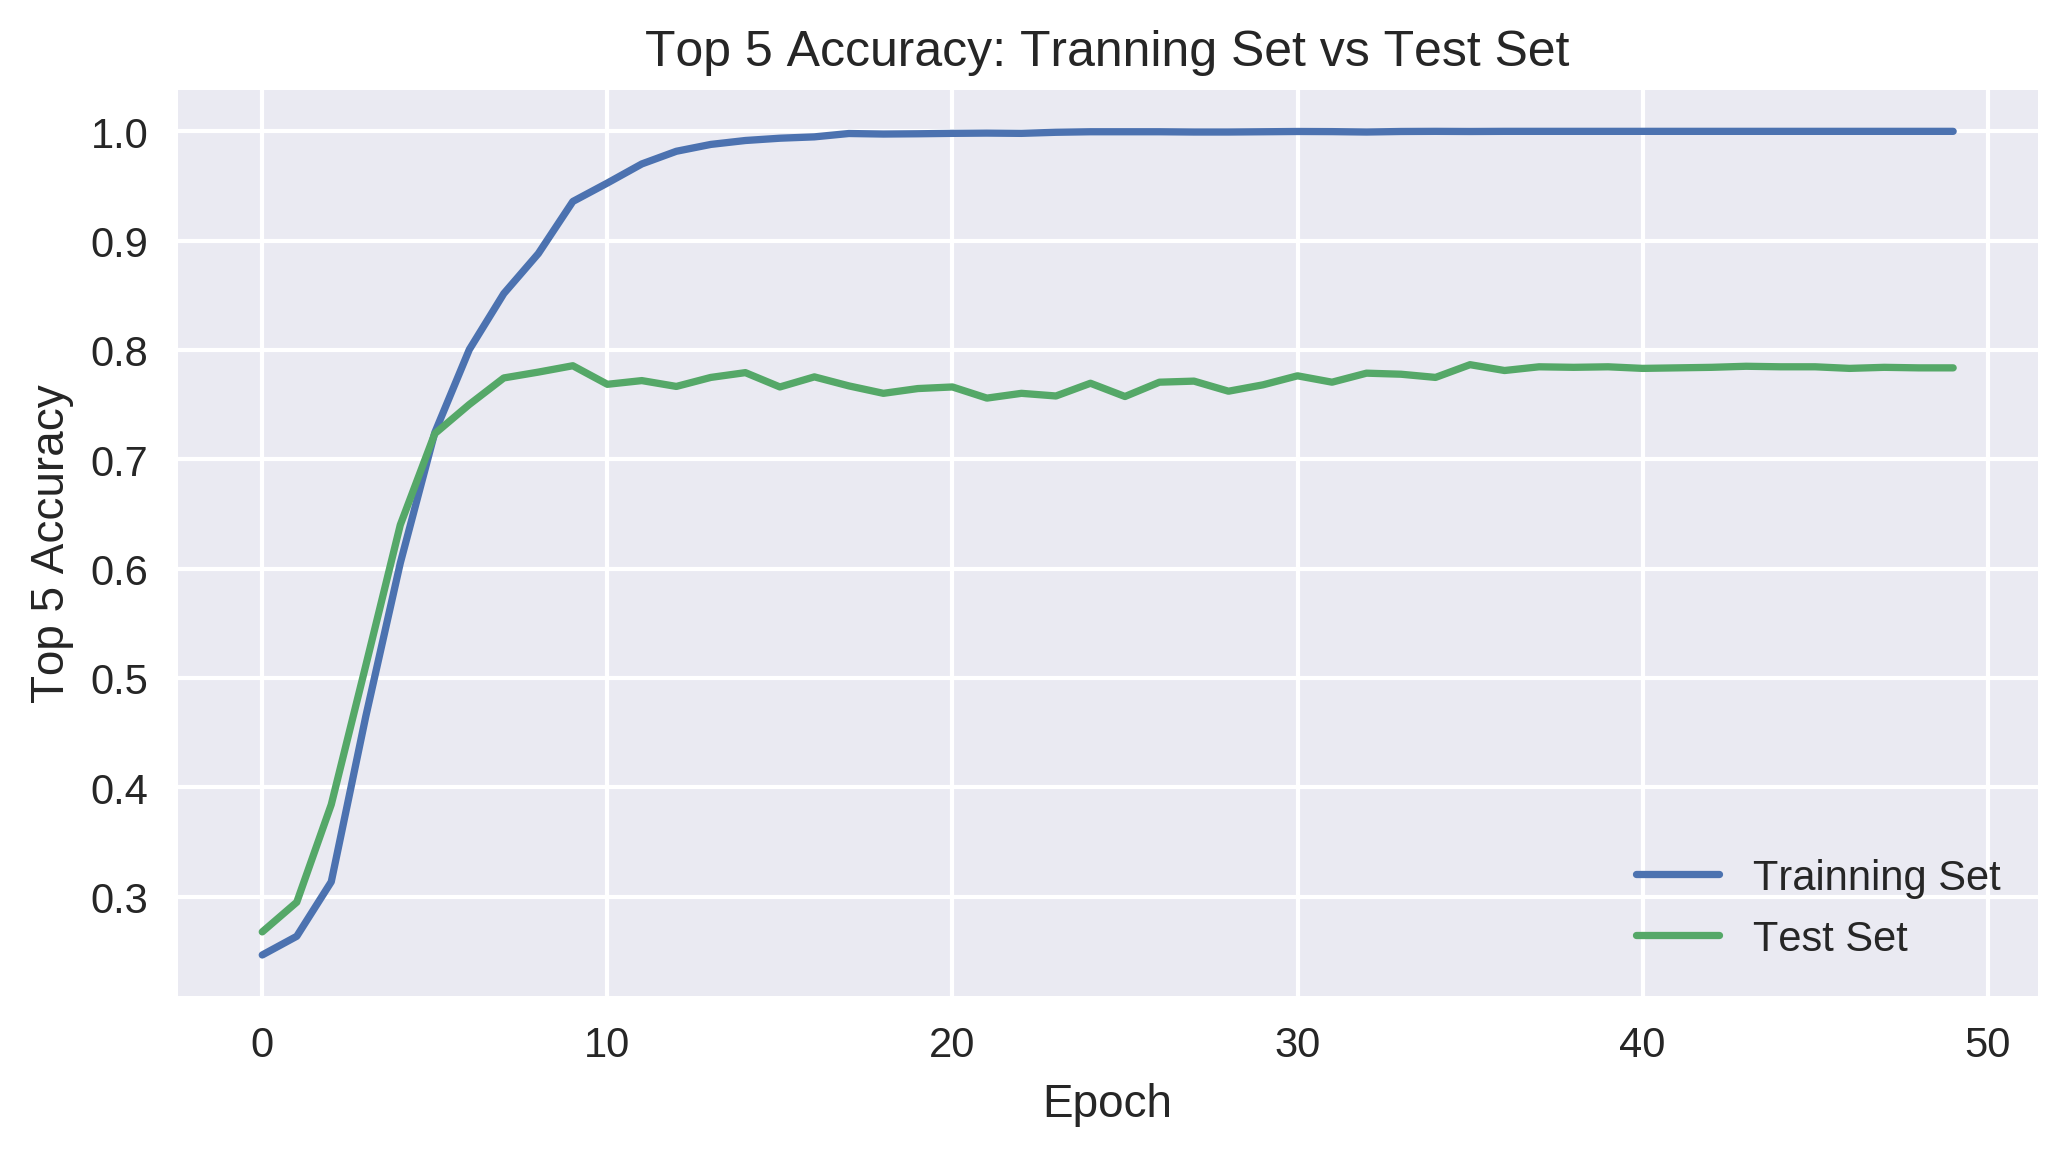

In [34]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 5 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 5 Accuracy")
plt.plot(history.history['top_k_categorical_accuracy'], label="Trainning Set")
plt.plot(history.history['val_top_k_categorical_accuracy'], label="Test Set")
plt.legend()
plt.show()

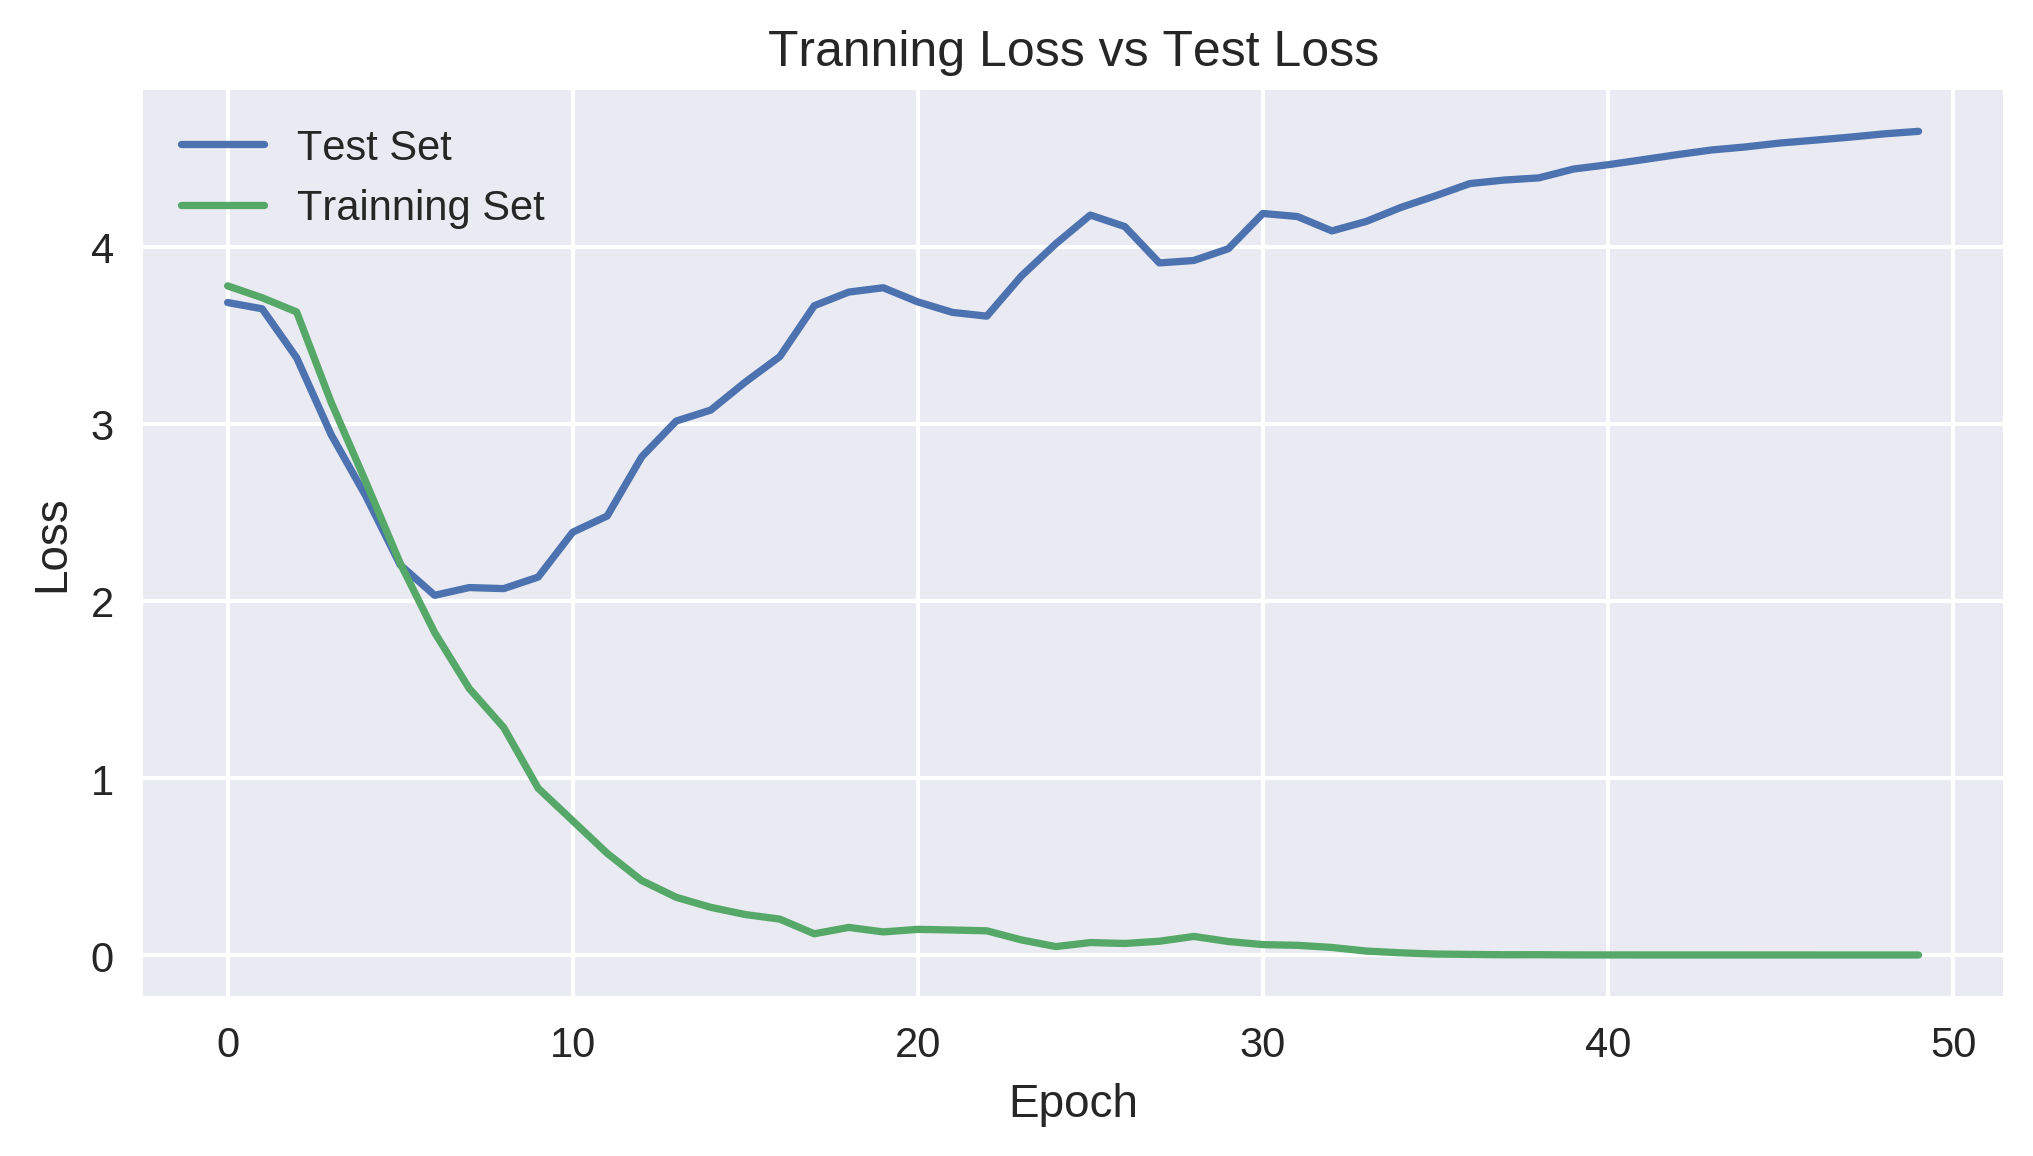

In [35]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Tranning Loss vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['val_loss'], label="Test Set")
plt.plot(history.history['loss'], label="Trainning Set")
plt.legend()
plt.show()


### Save History

In [0]:
import pickle
  
f = open('ServeNet/trainHistoryServeNet-1-BI-LTSM-LeNet-(1024-512)', 'wb')
pickle.dump(history.history, f)
f.close()
  

### Load History

In [0]:
import pickle

f = open('ServeNet/trainHistoryServeNet-1-BI-LTSM-LeNet-(1024-512)', 'rb')
his = pickle.load(f)
f.close()

In [39]:
val_top_k = his['val_top_k_categorical_accuracy']
print(max(val_top_k))
print(np.argmax(val_top_k))
val_loss = his['val_loss']
print(min(val_loss))
print(np.argmin(val_loss))
val_ca = his['val_categorical_accuracy']
print(max(val_ca))
print(np.argmax(val_ca))

0.7865114023765275
35
2.0324268537722183
6
0.5725376031197488
38


### Model Save

In [0]:
model.save('ServeNet/ServeNet-1-BI-LTSM-LeNet-(1024-512).h5') 

### Model Load

In [0]:
model = load_model('ServeNet/ServeNet-1-BI-LTSM-LeNet-(1024-512).h5')

In [42]:
print("Training set:")
loss_train, mae_train, top5error_train = model.evaluate(X_train, Y_train)
print("Training accuracy = ", top5error_train)
print('Test set:')
loss_test, mae_test, top5error_test = model.evaluate(X_test, Y_test)
print("Training accuracy = ", top5error_test)

Training set:
8123/8123 [==============================] - 37s 5ms/step
Training accuracy =  0.9998768927736058
Test set:
2061/2061 [==============================] - 9s 5ms/step
Training accuracy =  0.7836001941962244


In [0]:
# This code allows you to see the mislabelled examples
C = 50
# y_test_oh = np.eye(C)[Y_test.reshape(-1)]
# X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
predY_test = model.predict(X_test)

In [44]:
print(predY_test.shape)
print(Y_test.shape)

(2061, 50)
(2061, 50)


In [45]:
print(np.argmax(predY_test[0]))
print(np.argmax(Y_test[0]))

46
21


In [46]:
# Heatmap Data
non_onehot_pred_test = np.argmax(predY_test, axis=1)
non_onehot_Y_test = np.argmax(Y_test, axis=1)
categories = ['Financial', 'Project Management', 'Banking', 'Backend', 'Shipping', 'File Sharing', 'Email', 'Mapping', 'Domains', 'Social', 'Weather', 'Storage', 'Tools', 'Games', 'Events', 'Security', 'Analytics', 'Travel', 'Data', 'Reference', 'Office', 'Medical', 'Photos', 'Images', 'Education', 'Cloud', 'Chat', 'Application Development', 'Database', 'Messaging', 'News Services', 'Advertising', 'eCommerce', 'Transportation', 'Government', 'Other', 'Music', 'Sports', 'Internet of Things', 'Science', 'Telephony', 'Stocks', 'Media', 'Entertainment', 'Payments', 'Real Estate', 'Bitcoin', 'Search', 'Enterprise', 'Video', 'All']

print(non_onehot_pred_test.shape)
print(non_onehot_Y_test.shape)


(2061,)
(2061,)


In [0]:
# Heat Map

# cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test.reshape(len(non_onehot_pred_test),), rownames=['Actual'], colnames=['Predicted'], margins=True)
cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test, rownames=['Actual'], colnames=['Predicted'], margins=True)  

In [48]:
cross.index = categories
cross.index.name = "Actual"
cross.columns = categories
cross.columns.name = "Predicted"
cross.head()

Predicted,Financial,Project Management,Banking,Backend,Shipping,File Sharing,Email,Mapping,Domains,Social,...,Stocks,Media,Entertainment,Payments,Real Estate,Bitcoin,Search,Enterprise,Video,All
Actual,,,,,,,,,,,,,,,,,,,,,
Financial,4,0,0,0,1,5,0,0,0,0,...,0,0,0,0,0,0,1,0,0,16
Project Management,0,24,0,0,1,3,0,0,0,1,...,0,1,0,0,0,0,1,1,0,41
Banking,0,0,31,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,39
Backend,0,0,0,6,1,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,16
Shipping,0,1,1,0,9,0,0,0,0,1,...,0,0,0,0,0,0,2,0,0,28


In [49]:
sns.load_dataset("flights").head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


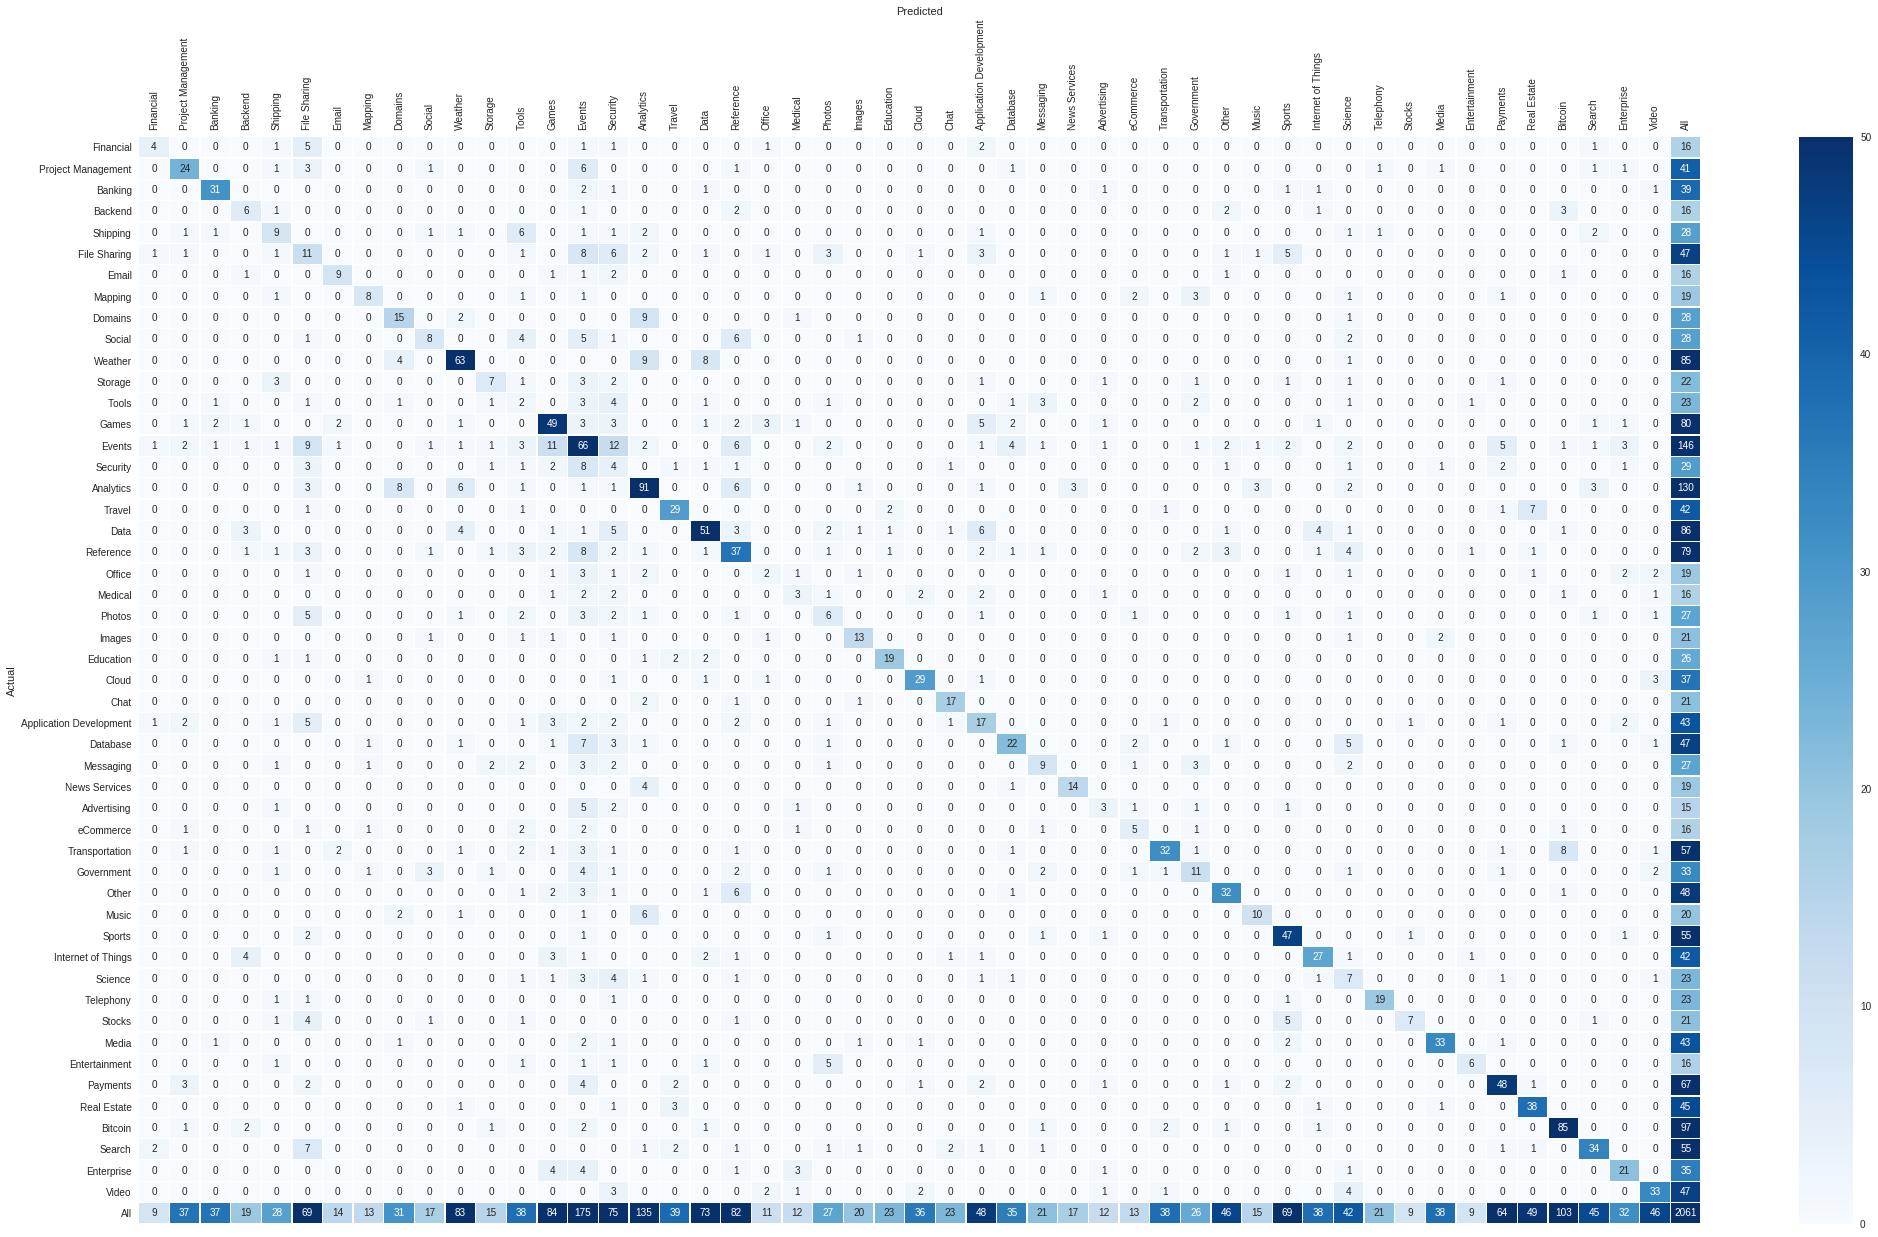

In [50]:
f, ax = plt.subplots(figsize=(35,20))

sns.heatmap(cross, annot=True, vmin=0, fmt="d", vmax=50, ax=ax, linewidths=.3, cmap=plt.cm.Blues)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


plt.yticks(rotation=0) 
plt.xticks(rotation=90) 

plt.savefig('ServeNet/heatmap.pdf', format='pdf', dpi=300)